# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis
from src.modeling.sec_quench import *
from src.utils.dataset_utils import *
from src.utils.utils import interp

import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_prim_quench_ee_plateau2 import RBFPAPrimQuenchEEPlateau2
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench
from src.utils.frequency_utils import get_fft_of_DataArray

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')


/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

3981

# Read metadata

In [5]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path, index_col=False)
rb_magnet_metadata

,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,...,Dcum2,QPS Crate,QPS Board,#Segment,phys_pos,Name,R_1,R_2,RRR_1,RRR_2
0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,...,268.9040,B8R1,0,79,1,A8R1,1.80,1.85,95.650088,94.103943
1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,...,284.5640,B9R1,0,77,2,B8R1,1.67,1.85,100.314516,94.103943
2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,...,307.9690,B8R1,1,80,3,A9R1,1.75,1.85,97.936878,94.103943
3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,...,323.6290,B11R1,2,76,4,B9R1,1.67,1.77,100.314516,97.371760
4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,...,348.4340,B10R1,0,81,5,A10R1,1.67,1.67,100.314516,100.314516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,...,26294.7892,B10L1,1,75,150,A10L1,2.53,3.13,78.314002,70.353447
1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,...,26319.5942,B9L1,1,80,151,B9L1,3.25,3.70,68.099268,54.735949
1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,...,26335.2542,B10L1,2,76,152,A9L1,3.09,1.75,70.748254,99.628927
1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,...,26358.6592,B9L1,0,79,153,B8L1,2.43,2.43,79.915648,79.899869


In [6]:
rb_magnet_metadata['cryostat_group'] = rb_magnet_metadata['Cryostat2'].apply(lambda x: x.split('_')[1])
last_mpos_in_cryostat = rb_magnet_metadata[rb_magnet_metadata.Circuit=='RB.A12'].groupby("cryostat_group").min().sort_values(by='phys_pos').phys_pos.values

# FFT Analysis

In [7]:
from scipy import signal
from scipy.fft import fft, fftfreq, rfft
from matplotlib import colors

def get_fft_amplitude(x):
    N = len(x)
    
    if np.isnan(x).all():
        y_FFT = fft(np.nan_to_num(x))
        y_FFT = np.zeros_like(y_FFT) * np.nan
    else:
        x = x[~np.isnan(x)]
        x = x * np.hanning(len(x))
        #x = pd.DataFrame(x).rolling(3).median().values.reshape(-1) #salt and peper noise
        y_FFT = fft(np.nan_to_num(x))
    return 2.0 / N * np.abs(y_FFT[0:N // 2])

def get_fft_amplitude_nohanning(x):
    N = len(x)
    
    if np.isnan(x).all():
        y_FFT = fft(np.nan_to_num(x))
        y_FFT = np.zeros_like(y_FFT) * np.nan
    else:
        x = x[~np.isnan(x)]
        #x = pd.DataFrame(x).rolling(3).median().values.reshape(-1) #salt and peper noise
        y_FFT = fft(np.nan_to_num(x))
    return 2.0 / N * np.abs(y_FFT[0:N // 2])

def get_fft_phase(DC_Down_data):
    N = len(DC_Down_data)
    x = fft(DC_Down_data)
    return np.arctan2(np.imag(x), np.real(x))[0:N // 2]


def plot_circuit_frequencies_phys_pos(ax, x_fft, frequency, rb_magnet_metadata_subset):
        
    phys_pos_index = rb_magnet_metadata_subset['#Electric_circuit'].values 
    
    im = ax.imshow(x_fft[phys_pos_index-1].T, extent=[1,154, frequency.min(),frequency.max()], vmin=1e-5, vmax=1e-2, aspect='auto', norm=colors.LogNorm(), origin='lower')
    ax.set_ylabel('Frequency / Hz')
    ax.set_xlabel('Phy. Position')
    ax.set_xticks(np.arange(1,155)[::9])
    
    last_mpos_in_cryostat = rb_magnet_metadata_subset.groupby("cryostat_group").min().sort_values(by='phys_pos').phys_pos.values
    ax.set_xticks(last_mpos_in_cryostat)
    tick_labels = [str(l) if i%3==0 else  '' for i, l in enumerate(last_mpos_in_cryostat)] 
    ax.set_xticklabels(tick_labels)

    plt.tight_layout()
    return im

def plot_circuit_frequencies(ax, x_fft, frequency, rb_magnet_metadata_subset):
    im = ax.imshow(x_fft.T, extent=[1,154, frequency.min(),frequency.max()], vmin=1e-5, vmax=1e-2, aspect='auto', norm=colors.LogNorm(), origin='lower')
    
    ax.set_ylabel('Frequency / Hz')
    ax.set_xlabel('El. Position')
    ax.set_xticks(np.arange(1,155)[::9])

    plt.tight_layout()
    return im


In [8]:
dataset_path_1EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
dataset_path_2EE = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_RBFPAPrimQuenchEEPlateau2")

dataset_creator_1EE = RBFPAPrimQuenchEEPlateau()
dataset_creator_2EE = RBFPAPrimQuenchEEPlateau2()

fpa_identifiers = mp3_fpa_df[#(mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 > sec_after_prim_quench) &
                             (mp3_fpa_df['timestamp_fgc'] > 1611836512820000000)
                             ].fpa_identifier.unique()

dataset_1EE = dataset_creator_1EE.load_dataset(fpa_identifiers=fpa_identifiers,
                                       dataset_path=dataset_path_1EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

dataset_2EE = dataset_creator_2EE.load_dataset(fpa_identifiers=fpa_identifiers,
                                       dataset_path=dataset_path_2EE,
                                       drop_data_vars=['simulation', 'el_position_feature', 'event_feature'])

max_freq = 360
dataset_1EE_fft = get_fft_of_DataArray(data=dataset_1EE.data, cutoff_frequency=max_freq)
dataset_2EE_fft = get_fft_of_DataArray(data=dataset_2EE.data, cutoff_frequency=max_freq)

# Sanity Check 

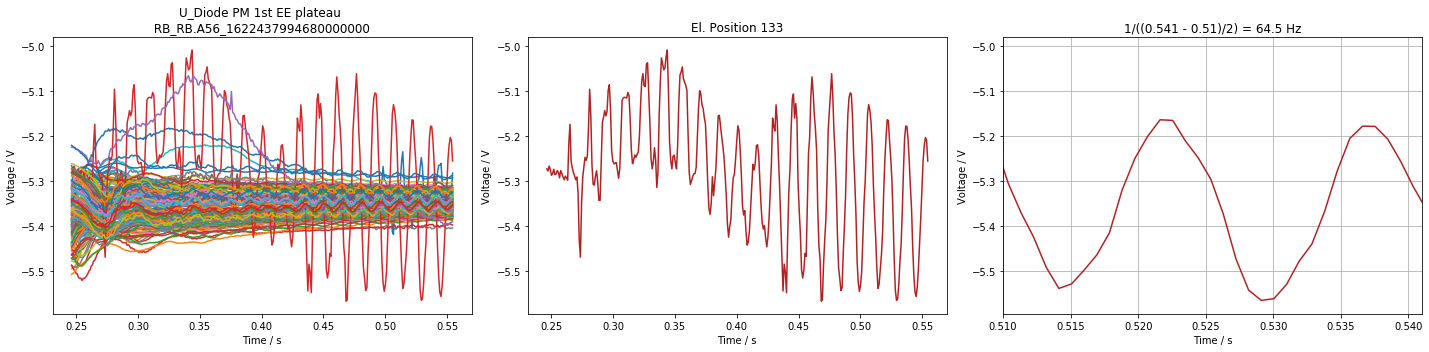

In [10]:
fpa_identifier = "RB_RB.A56_1622437994680000000"
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].set_title(f'U_Diode PM 1st EE plateau \n {fpa_identifier} ')
ax[0].plot(dataset_1EE.loc[{'event': fpa_identifier}].time, dataset_1EE.loc[{'event': fpa_identifier}].data.T )
ax[0].set_xlabel('Time / s')
ax[0].set_ylabel('Voltage / V')

ax[1].set_title('El. Position 133')
ax[1].plot(dataset_1EE.loc[{'event': fpa_identifier}].time, dataset_1EE.loc[{'event': fpa_identifier}].data[133], c='firebrick')
ax[1].set_xlabel('Time / s')
ax[1].set_ylabel('Voltage / V')

ax[2].plot(dataset_1EE.loc[{'event': fpa_identifier}].time, dataset_1EE.loc[{'event': fpa_identifier}].data[133], c='firebrick')
ax[2].set_xlabel('Time / s')
ax[2].set_ylabel('Voltage / V')
ax[2].set_xlim((0.51,0.541))
ax[2].set_title('1/((0.541 - 0.51)/2) = 64.5 Hz')

plt.grid()
plt.tight_layout()

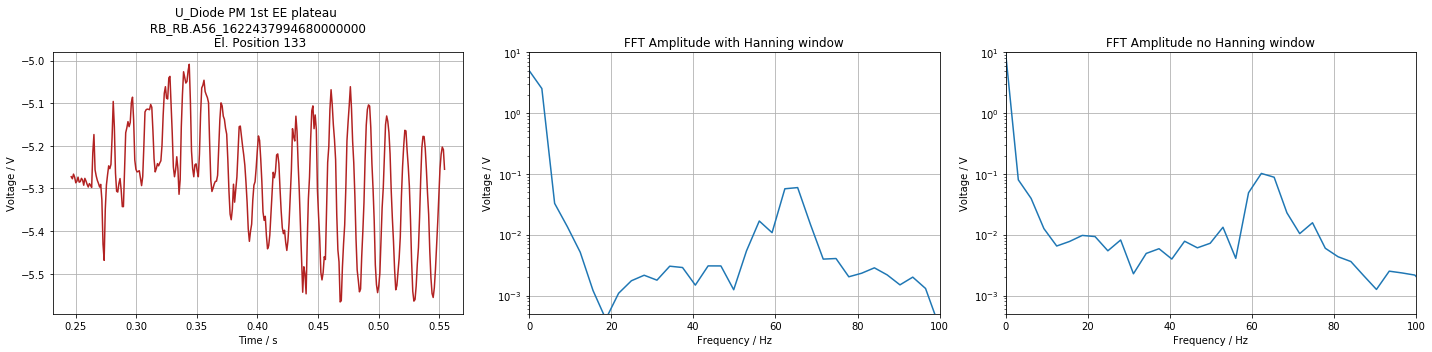

In [11]:
fig, ax = plt.subplots(1,3,figsize=(20,5))

x_t = np.array(dataset_1EE.loc[{'event': fpa_identifier}].data[133])
x_fft = get_fft_amplitude(x_t)
x_fft_nohanning = get_fft_amplitude_nohanning(x_t)

dt = dataset_1EE.loc[{'event': fpa_identifier}].time[1].values - dataset_1EE.loc[{'event': fpa_identifier}].time[0].values
frequency = fftfreq(len(x_t), dt)[:len(x_t)//2] 

ax[0].set_title(f'U_Diode PM 1st EE plateau \n {fpa_identifier} \n El. Position 133')
ax[0].plot(dataset_1EE.loc[{'event': fpa_identifier}].time, x_t, c='firebrick')
#ax[0].plot(dataset.loc[{'event': fpa_identifier}].time, x_time * np.hanning(len(x_time)), c='firebrick') 
ax[0].set_xlabel('Time / s')
ax[0].set_ylabel('Voltage / V')
ax[0].grid()

ax[1].set_title(f'FFT Amplitude with Hanning window')
ax[1].plot(frequency, x_fft)
ax[1].set_xlabel('Frequency / Hz')
ax[1].set_ylabel('Voltage / V')
ax[1].set_yscale('log')
ax[1].grid()
ax[1].set_xlim((0,100))
ax[1].set_ylim((5e-4,10))

ax[2].set_title(f'FFT Amplitude no Hanning window')
ax[2].plot(frequency, x_fft_nohanning)
ax[2].set_xlabel('Frequency / Hz')
ax[2].set_ylabel('Voltage / V')
ax[2].set_yscale('log')
ax[2].grid()
ax[2].set_xlim((0,100))
ax[2].set_ylim((5e-4,10))

plt.tight_layout()

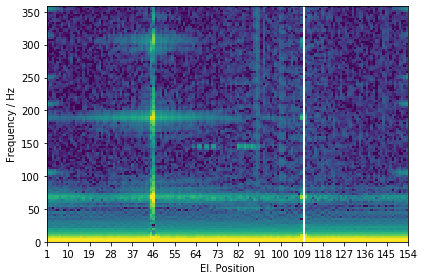

In [25]:
fpa_identifier =  dataset_1EE[{'event': 1}].event.values


circuit = str(fpa_identifier).split('_')[1]
rb_magnet_metadata_subset = rb_magnet_metadata[rb_magnet_metadata.Circuit==circuit]

fig, ax = plt.subplots()
x_fft = dataset_1EE_fft[{'event': 1}].data
plot_circuit_frequencies(ax, x_fft, dataset_1EE_fft[{'event': 1}].frequency, rb_magnet_metadata_subset)  

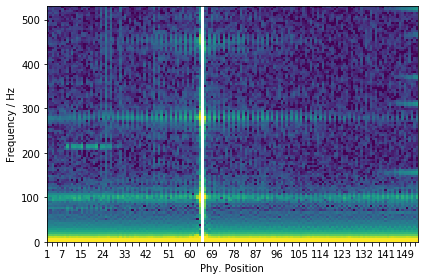

In [27]:
fig, ax = plt.subplots()
plot_circuit_frequencies_phys_pos(ax, x_fft, frequency, rb_magnet_metadata_subset)

# Manually analyze fast secondary quenches

In [11]:
all_fpa_identifiers = mp3_fpa_df[#(mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 > sec_after_prim_quench) &
                             (mp3_fpa_df['timestamp_fgc'] > 1611836512820000000)
                             ].fpa_identifier.unique()

fpa_identifiers = [fi  for fi in all_fpa_identifiers if fi in dataset_1EE.event]
len(fpa_identifiers)

543

In [12]:
plot_dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/FFT_analysis")

img_phys_pos1 = plt.imread('../documentation/1_phys_pos.png')
img_phys_pos2 = plt.imread('../documentation/2_phys_pos.png')
img_el_pos1 = plt.imread('../documentation/1_el_pos.png')
img_el_pos2 = plt.imread('../documentation/2_el_pos.png')

for example in fpa_identifiers:
    fpa_identifier =  dataset_1EE.loc[{'event': example}].event.values
    
    if not os.path.isfile(plot_dataset_path / f"{fpa_identifier}.png"):
        n_magnets = len(dataset_1EE.loc[{'event': example}].data)
        circuit = example.split('_')[1]
        fig, ax = plt.subplots(4,4, figsize=(25,12), gridspec_kw={'height_ratios': [0.2, 1.2, 5,5], 'width_ratios': [4, 4, 4, 1]})
        date = mp3_fpa_df[mp3_fpa_df['fpa_identifier'] == fpa_identifier]['Timestamp_PIC'].values[0]

        mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df['fpa_identifier'] == fpa_identifier)]
        current = mp3_fpa_df_subset['I_end_2_from_data'].values[0]
        mp3_fpa_df_subset_fast = mp3_fpa_df_subset[mp3_fpa_df_subset['Delta_t(iQPS-PIC)'] / 1000 < 1]

        rb_magnet_metadata_subset = rb_magnet_metadata[rb_magnet_metadata.Circuit==circuit]

        prim_quench_position = mp3_fpa_df_subset_fast['#Electric_circuit'].values[0]
        sec_quench_position = mp3_fpa_df_subset_fast['#Electric_circuit'].values[1:]

        prim_quench_position_phys = mp3_fpa_df_subset_fast['phys_position'].values[0]
        sec_quench_position_phys = mp3_fpa_df_subset_fast['phys_position'].values[1:]
        sec_quench_times = mp3_fpa_df_subset_fast['Delta_t(iQPS-PIC)'].values[1:] 

        sec_quench_phys = [f"{int(pos)}@{int(time)}ms" for pos, time in zip(sec_quench_position_phys, sec_quench_times)]
        sec_quench_el = [f"{int(pos)}@{int(time)}ms" for pos, time in zip(sec_quench_position, sec_quench_times)]

        ax[0,0].text(0,1, f"FPA identifier: {fpa_identifier} \nDate: {date} \nMax. Current: {current} A")

        ax[0,1].text(0,3,   f"El. Position Primary")
        ax[0,1].text(0,1.5, f"Primary quench position: {int(prim_quench_position)}", c="r")
        ax[0,1].text(0,0,   f"Fast secondary quench: {sec_quench_el}", c="orange")


        ax[0,2].text(0,3,   f"Phys. Position Primary")
        ax[0,2].text(0,1.5, f"Primary quench position: {int(prim_quench_position_phys)}", c="r")
        ax[0,2].text(0,0,   f"Fast secondary quench: {sec_quench_phys}", c="orange")

        if int(circuit[-2]) %2==0:
            ax[1,1].imshow(img_el_pos2)
            ax[1,2].imshow(img_phys_pos2)
        else:
            ax[1,1].imshow(img_el_pos1)
            ax[1,2].imshow(img_phys_pos1)

        ax[1,1].set_title(f'Sector: {circuit}')
        ax[1,2].set_title(f'Sector: {circuit}')

        ax[1,0].set_axis_off()
        ax[1,1].set_axis_off()
        ax[1,2].set_axis_off()

        ax[0,0].set_axis_off()
        ax[0,1].set_axis_off()
        ax[0,2].set_axis_off()

        ax[0,3].set_axis_off()
        ax[1,3].set_axis_off()
        ax[2,3].set_axis_off()
        ax[3,3].set_axis_off()

        ax[1, 0].set_title("U_Diode Signals")
        colors_1 = list(zip(np.linspace(0.5, 1 ,128), mpl.cm.jet(np.linspace(0,1,128))))
        colors_2 = list(zip(np.linspace(0,0.5,128), mpl.cm.jet(np.linspace(1,0,128))))
        cmap = mpl.cm.jet #mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors_2 + colors_1)
        norm = mpl.colors.Normalize(vmin=1, vmax=154)
        cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1, 0], fraction=1, orientation = 'horizontal')
        cbar.set_label('El. Position')


        for i, x in enumerate(dataset_1EE.loc[{'event': example}].data):
            ax[2, 0].plot(dataset_1EE.loc[{'event': example}].time, x, c=cmap(i/n_magnets))
        ax[2, 0].grid()
        ax[2, 0].set_title(f"U_Diode @ 1st EE plateau")
        ax[2, 0].set_xlabel('Time / s')
        ax[2, 0].set_ylabel('Voltage / V')
        for t in sec_quench_times:
            ax[2, 0].axvline(x = t / 1000, color = 'r')
        ax[2, 0].set_xlim(dataset_1EE.loc[{'event': example}].time.min(),dataset_1EE.loc[{'event': example}].time.max())

        x_fft = dataset_1EE_fft.loc[{'event': example}].data
        frequency = dataset_1EE_fft.loc[{'event': example}].frequency
        im = plot_circuit_frequencies(ax[2, 1], x_fft, frequency, rb_magnet_metadata_subset)       
        ax[2, 1].set_title(f'El. Position')
        ax[2, 1].tick_params(axis='x', colors='red')

        im1 = plot_circuit_frequencies_phys_pos(ax[2, 2], x_fft, frequency, rb_magnet_metadata_subset)
        ax[2, 2].set_title(f'Phys. Position')
        ax[2, 2].grid(linewidth=0.2)
        ax[2, 1].axvline(x = prim_quench_position, color = 'red')
        ax[2, 2].axvline(x = prim_quench_position_phys, color = 'red')
        for e, p in zip(sec_quench_position, sec_quench_position_phys):
            ax[2, 1].axvline(x = e, color = 'orange')
            ax[2, 2].axvline(x = p, color = 'orange')
        cbar = fig.colorbar(im, ax=ax[2, 3],fraction=1)
        cbar.set_label('Voltage / V')


        for i, x in enumerate(dataset_2EE.loc[{'event': example}].data):
            ax[3, 0].plot(dataset_2EE.loc[{'event': example}].time, x, c=cmap(i/n_magnets))
        ax[3, 0].grid()
        ax[3, 0].set_title(f"U_Diode @ 2nd EE plateau")
        ax[3, 0].set_xlabel('Time / s')
        ax[3, 0].set_ylabel('Voltage / V')
        for t in sec_quench_times:
            ax[3, 0].axvline(x = t / 1000, color = 'r')
        ax[3, 0].set_xlim(dataset_2EE.loc[{'event': example}].time.min(), dataset_2EE.loc[{'event': example}].time.max())
        #ax[3, 0].text(0.45, -4.9, "12")

        x_fft = dataset_2EE_fft.loc[{'event': example}].data
        frequency = dataset_2EE_fft.loc[{'event': example}].frequency
        im = plot_circuit_frequencies(ax[3, 1], x_fft, frequency, rb_magnet_metadata_subset)       
        ax[3, 1].set_title(f'El. Position')
        ax[3, 1].tick_params(axis='x', colors='red')


        im1 = plot_circuit_frequencies_phys_pos(ax[3, 2], x_fft, frequency, rb_magnet_metadata_subset)
        ax[3, 2].set_title(f'Phys. Position')
        ax[3, 2].grid(linewidth=0.2)
        ax[3, 1].axvline(x = prim_quench_position, color = 'red')
        ax[3, 2].axvline(x = prim_quench_position_phys, color = 'red')
        for e, p in zip(sec_quench_position, sec_quench_position_phys):
            ax[3, 1].axvline(x = e, color = 'orange')
            ax[3, 2].axvline(x = p, color = 'orange')
        cbar = fig.colorbar(im, ax=ax[3, 3], fraction=1)
        cbar.set_label('Voltage / V')

        plt.tight_layout()
        plt.savefig(plot_dataset_path / f"{fpa_identifier}.png", dpi=400)
        plt.close(fig)